In [495]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import yfinance as yfin
from pandas_datareader import data as pdr
from pyhhmm.gaussian import GaussianHMM

yfin.pdr_override()
import random

import joblib
import matplotlib.pyplot as plt
from ta import add_trend_ta

In [496]:
def get_yahoo_data(symbol, start_date, end_date):
    data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
    data = data[["Open", "High", "Low", "Adj Close", "Volume"]]
    return data

In [497]:
start_date = "2019-01-1"
end_date = "2024-02-13"
symbol = "SPY"
data = get_yahoo_data(symbol, start_date, end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2019-01-02,245.979996,251.210007,245.949997,230.557434,126925200
2019-01-03,248.229996,248.570007,243.669998,225.055679,144140700
2019-01-04,247.589996,253.110001,247.169998,232.594131,142628800
2019-01-07,252.690002,255.949997,251.690002,234.428055,103139100
2019-01-08,256.820007,257.309998,254.000000,236.630585,102512600
...,...,...,...,...,...
2024-02-06,493.519989,494.320007,492.049988,493.980011,55918600
2024-02-07,496.290009,498.529999,495.359985,498.100006,70556500
2024-02-08,498.100006,498.709991,497.260010,498.320007,52343600


In [498]:
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df_trend = add_trend_ta(df.copy(), high="High", low="Low", close="Adj Close", fillna=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,225.055679,144140700,-0.023863,0.020109
2019-01-04,247.589996,253.110001,247.169998,232.594131,142628800,0.033496,0.024032
2019-01-07,252.690002,255.949997,251.690002,234.428055,103139100,0.007885,0.016926
2019-01-08,256.820007,257.309998,254.000000,236.630585,102512600,0.009395,0.013031
2019-01-09,257.559998,258.910004,256.190002,237.736450,95006600,0.004673,0.010617


In [499]:
df_trend

,Open,High,Low,Adj Close,Volume,Returns,Range,trend_macd,trend_macd_signal,trend_macd_diff,...,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,248.229996,248.570007,243.669998,225.055679,144140700,-0.023863,0.020109,0.000000,0.000000,0.000000,...,0.000000,374.452355,369.985206,0.0,0.0,0.0,232.913649,273.440002,0.0,0.0
2019-01-04,247.589996,253.110001,247.169998,232.594131,142628800,0.033496,0.024032,0.601358,0.120272,0.481086,...,66.666667,374.452355,369.985206,4.0,0.0,4.0,232.913649,273.440002,0.0,0.0
2019-01-07,252.690002,255.949997,251.690002,234.428055,103139100,0.007885,0.016926,1.211950,0.338607,0.873343,...,84.177466,374.452355,369.985206,8.0,0.0,8.0,232.913649,273.440002,1.0,0.0
2019-01-08,256.820007,257.309998,254.000000,236.630585,102512600,0.009395,0.013031,1.852223,0.641331,1.210893,...,86.320957,374.452355,369.985206,12.0,0.0,12.0,233.835103,273.440002,0.0,0.0
2019-01-09,257.559998,258.910004,256.190002,237.736450,95006600,0.004673,0.010617,2.420971,0.997259,1.423713,...,87.743483,374.452355,369.985206,16.0,0.0,16.0,235.243597,273.440002,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-06,493.519989,494.320007,492.049988,493.980011,55918600,0.002903,0.004613,6.218376,5.891534,0.326842,...,108.980223,468.622490,443.379990,92.0,16.0,76.0,483.382309,491.619995,0.0,0.0
2024-02-07,496.290009,498.529999,495.359985,498.100006,70556500,0.008340,0.006399,6.542901,6.021808,0.521093,...,139.217888,469.064995,443.379990,100.0,12.0,88.0,483.635663,491.619995,0.0,0.0
2024-02-08,498.100006,498.709991,497.260010,498.320007,52343600,0.000442,0.002916,6.740145,6.165475,0.574670,...,133.401627,469.064995,443.379990,100.0,8.0,92.0,484.231436,491.619995,0.0,0.0


In [500]:
df_trends_only = df_trend.copy()
columns_to_remove = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Returns', 'Range']  # List of columns to remove
df_trends_only.drop(columns=columns_to_remove, inplace=True)
df_trends_only

,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,...,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.000000,0.000000,0.000000,225.055679,225.055679,225.055679,225.055679,0.000000,0.000000,0.000000,...,0.000000,374.452355,369.985206,0.0,0.0,0.0,232.913649,273.440002,0.0,0.0
2019-01-04,0.601358,0.120272,0.481086,228.824905,228.824905,226.215441,225.614083,0.063579,0.009429,0.054150,...,66.666667,374.452355,369.985206,4.0,0.0,4.0,232.913649,273.440002,0.0,0.0
2019-01-07,1.211950,0.338607,0.873343,230.692622,230.692622,227.478920,226.266970,0.106034,0.016411,0.089622,...,84.177466,374.452355,369.985206,8.0,0.0,8.0,232.913649,273.440002,1.0,0.0
2019-01-08,1.852223,0.641331,1.210893,232.177113,232.177113,228.886869,227.034645,0.122436,0.024498,0.097939,...,86.320957,374.452355,369.985206,12.0,0.0,12.0,233.835103,273.440002,0.0,0.0
2019-01-09,2.420971,0.997259,1.423713,233.288980,233.288980,230.248343,227.827371,0.132493,0.027144,0.105349,...,87.743483,374.452355,369.985206,16.0,0.0,16.0,235.243597,273.440002,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-06,6.218376,5.891534,0.326842,488.688337,480.785386,488.257650,482.039274,1.354580,0.580995,0.773586,...,108.980223,468.622490,443.379990,92.0,16.0,76.0,483.382309,491.619995,0.0,0.0
2024-02-07,6.542901,6.021808,0.521093,489.909170,481.661925,489.771859,483.228957,1.347551,0.594607,0.752944,...,139.217888,469.064995,443.379990,100.0,12.0,88.0,483.635663,491.619995,0.0,0.0
2024-02-08,6.740145,6.165475,0.574670,491.030838,482.649233,491.086958,484.346813,1.338102,0.661340,0.676762,...,133.401627,469.064995,443.379990,100.0,8.0,92.0,484.231436,491.619995,0.0,0.0


In [501]:
# Assuming df is your DataFrame
# Extract column names from the DataFrame
column_names = df_trends_only.columns.tolist()

# # Load column values into a list of lists
# column_values = [df_trends_only[column].tolist() for column in column_names]

# print(column_names)

# # Flatten the list of lists into a single list
# all_values = [item for sublist in column_values for item in sublist]

# Randomly select items from the list
num_samples = 10  # Number of random items to select
random_items = random.sample(column_names, num_samples)

# Display the randomly selected items
print(random_items)

['trend_psar_down', 'trend_kst', 'trend_sma_slow', 'trend_vortex_ind_diff', 'trend_aroon_ind', 'trend_macd', 'trend_dpo', 'trend_ichimoku_a', 'trend_ichimoku_b', 'trend_stc']


In [502]:
df["MA_72"] = df_trend["Adj Close"].rolling(window=12).mean()
df["MA_161"] = df_trend["Adj Close"].rolling(window=21).mean()

In [503]:
# X_train = df[["Returns", "Range", "trend_adx", "trend_macd"]]
df_dataset = df.iloc[:500]
X_train = df_trend[
    ["Returns", "Range"]
].iloc[:500]
X_test = df_trend[
    ["Returns", "Range"]
].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  786
X_train From:  2019-01-03 00:00:00
X_train To:  2020-12-24 00:00:00
X_test From:  2020-12-28 00:00:00
X_test To:  2024-02-12 00:00:00


In [504]:
np.array(X_train.values)[:2]

array([[-0.02386284,  0.0201092 ],
       [ 0.03349594,  0.02403205]])

In [505]:
def list_shape(lst):
    if not isinstance(lst, list):
        return ()
    return (len(lst),) + list_shape(lst[0])

In [506]:
train_set = [np.array(X_train.values)]
print("Shape:", list_shape(train_set))

Shape: (1,)


In [507]:
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])

(<pyhhmm.gaussian.GaussianHMM at 0x139164a10>, 3363.3293978207157)

In [508]:
# model.n_states

In [509]:
joblib.dump(model, "models/gaussian_hmm_model.pkl")
loaded_model = joblib.load("models/gaussian_hmm_model.pkl")
loaded_model

In [510]:
model.predict([X_train.values])[0][:10]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [511]:
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]


500

In [512]:
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df_dataset["Adj Close"].values.astype(float)
print(len(prices), len(hidden_states))
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

500 500
Correct number of rows:  True


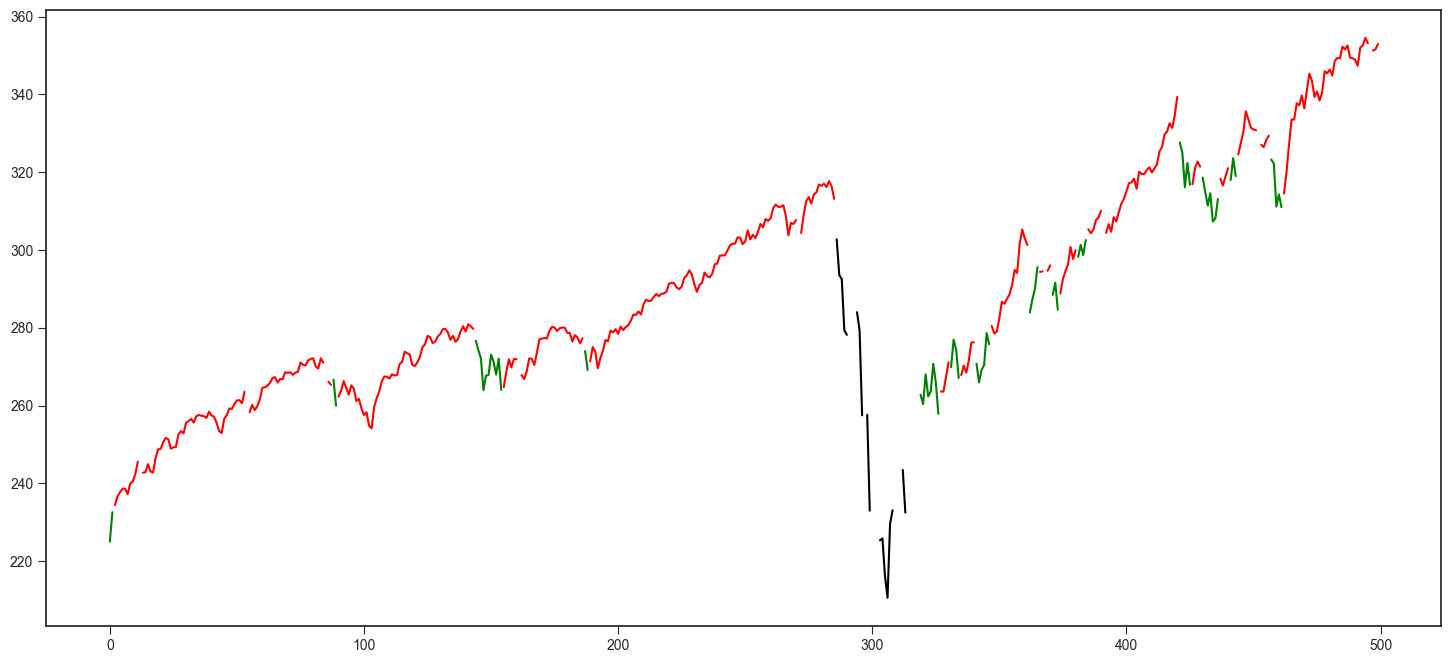

In [513]:
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="red")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

In [514]:
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Adj Close,Volume,Returns,Range,MA_72,MA_161,HMM
Date,,,,,,,,
2020-12-28,371.739990,356.000275,39000400,0.008591,0.004096,351.798704,350.759238,0
2020-12-29,373.809998,355.321136,53680500,-0.001908,0.008548,352.299825,351.184386,1
2020-12-30,372.339996,355.828094,49455300,0.001427,0.004118,352.877324,351.706698,1
2020-12-31,371.779999,357.635986,78520700,0.005081,0.009240,353.735654,352.135489,1
2021-01-04,375.309998,352.767151,110210800,-0.013614,0.029138,353.796933,352.297504,0


In [515]:
# Add MA Signals
df_main.loc[df_main["MA_72"] > df_main["MA_161"], "MA_Signal"] = 1
df_main.loc[df_main["MA_72"] <= df_main["MA_161"], "MA_Signal"] = 0

In [516]:
# Add HMM Signals
favourable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [517]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [518]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [519]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [520]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Volume,Returns,Range,MA_72,MA_161,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2024-02-05,493.700012,492.549988,75757100,-0.003641,0.008465,487.725835,482.019525,1,1.0,1,1.0,-0.003648,0.324664,0.383566,-0.000365,0.027030,0.027398
2024-02-06,493.519989,493.980011,55918600,0.002903,0.004613,488.688337,483.260478,1,1.0,1,1.0,0.002899,0.327564,0.387583,0.005597,0.032627,0.033165
2024-02-07,496.290009,498.100006,70556500,0.008340,0.006399,489.909170,484.379525,1,1.0,1,1.0,0.008306,0.335869,0.399156,0.003640,0.036267,0.036933
2024-02-08,498.100006,498.320007,52343600,0.000442,0.002916,491.030838,485.543335,1,1.0,1,1.0,0.000442,0.336311,0.399774,0.001485,0.037752,0.038473
2024-02-09,498.839996,501.200012,63917600,0.005779,0.006339,492.348338,486.716669,1,1.0,1,1.0,0.005763,0.342074,0.407864,0.004660,0.042412,0.043324


In [521]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [522]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [523]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 40.8%
Returns Strategy: 4.3%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.58
Sharpe Strategy: 0.03


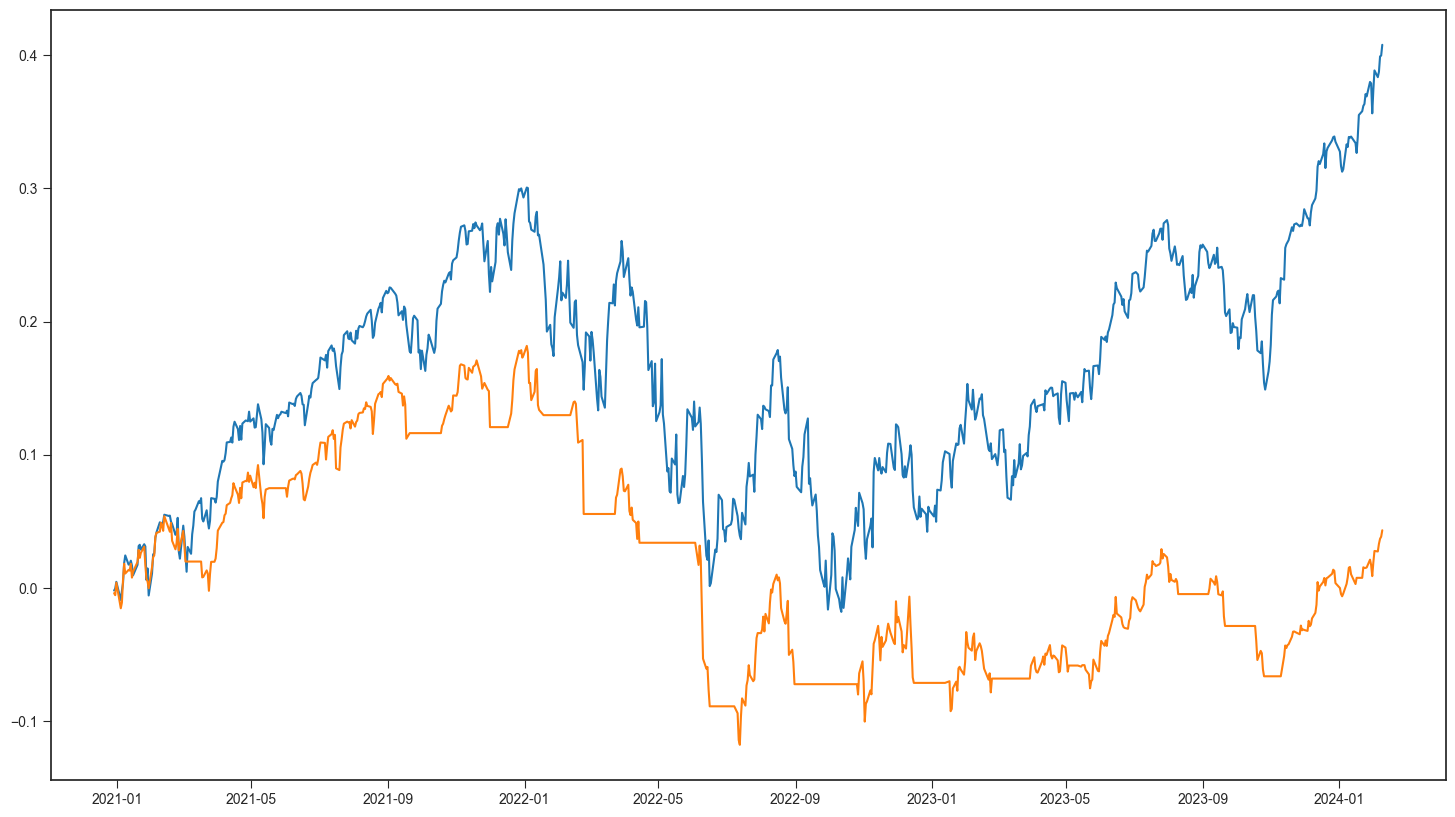

In [524]:
# Plot Equity Curves
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["bench_prod_exp"])
plt.plot(df_main["strat_prod_exp"])
plt.show()